In [19]:
# --- Imports ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import umap
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.offsetbox as offsetbox
from tqdm.auto import tqdm

In [3]:
# --- Load Data ---
df = pd.read_parquet("../data/marker_embeddings_subset.parquet")

# --- Check data ---
print(f"Number of samples: {len(df)}")
print("Available columns:", df.columns.tolist())

Number of samples: 734
Available columns: ['image_path', 'embedding', 'marker', 'sample_id']


In [4]:
# --- Prepare Embeddings ---
# Expand embedding array into 2D matrix
embeddings = np.vstack(df['embedding'].values)

# Optional: Standardize features before UMAP
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

In [5]:
# --- Run UMAP ---
reducer = umap.UMAP(random_state=42)
embedding_2d = reducer.fit_transform(embeddings_scaled)

# --- Add UMAP coordinates to DataFrame ---
df['UMAP_1'] = embedding_2d[:, 0]
df['UMAP_2'] = embedding_2d[:, 1]

/home/meyerben/meyerben/.conda/envs/huggingface_env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/meyerben/meyerben/.conda/envs/huggingface_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


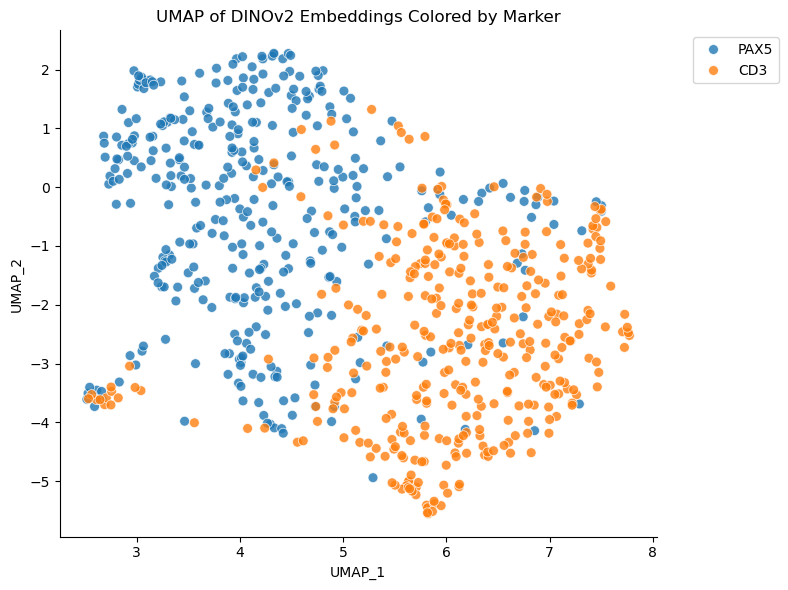

In [6]:
# --- Plot ---
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x="UMAP_1", y="UMAP_2",
    hue="marker",
    palette="tab10",  # Customize as needed
    s=50,
    alpha=0.8
)
plt.title("UMAP of DINOv2 Embeddings Colored by Marker")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
sns.despine()
plt.tight_layout()
plt.show()

In [39]:
import matplotlib.pyplot as plt
from matplotlib import offsetbox, patches
from matplotlib.colors import Normalize, to_hex
from matplotlib.cm import get_cmap
from PIL import Image
import numpy as np
import pandas as pd

def load_image_with_viridis_colormap(path, image_size=(20, 20)):
    """Load grayscale image, normalize, apply viridis colormap, and return RGB PIL image."""
    img = Image.open(path).convert("L")  # Grayscale
    img = img.resize(image_size, resample=Image.Resampling.LANCZOS)
    img_np = np.array(img).astype(np.float32)

    if np.isnan(img_np).all() or np.max(img_np) == np.min(img_np):
        normed = np.zeros_like(img_np)
    else:
        normed = (img_np - np.min(img_np)) / (np.max(img_np) - np.min(img_np))

    cmap = get_cmap("viridis")
    img_rgb = (cmap(normed)[..., :3] * 255).astype(np.uint8)
    return Image.fromarray(img_rgb)

def plot_umap_with_images_colored(df, fraction=0.1, image_size=(20, 20), colormap='tab10'):
    """
    Plots UMAP embeddings with images instead of points, using colored borders to indicate markers.
    Adds a legend and removes padding between image and border.
    """
    df_sampled = df.sample(frac=fraction, random_state=42) if fraction < 1.0 else df

    # Assign colors to markers
    unique_markers = sorted(df_sampled['marker'].unique())
    cmap = get_cmap(colormap)
    marker_to_color = {
        marker: cmap(i / max(len(unique_markers) - 1, 1))
        for i, marker in enumerate(unique_markers)
    }

    fig, ax = plt.subplots(figsize=(14, 8), dpi=300)

    for _, row in tqdm(df_sampled.iterrows(), total=df_sampled.shape[0]):
        try:
            img = load_image_with_viridis_colormap(row['image_path'], image_size=image_size)
            border_color = marker_to_color[row['marker']]

            imagebox = offsetbox.OffsetImage(img, zoom=1.0)
            ab = offsetbox.AnnotationBbox(
                imagebox,
                (row['UMAP_1'], row['UMAP_2']),
                pad=0,
                frameon=True,
                bboxprops=dict(edgecolor=to_hex(border_color), linewidth=5)
            )
            ax.add_artist(ab)
        except Exception as e:
            print(f"Could not load image {row['image_path']}: {e}")

    # Create legend
    legend_handles = [
        patches.Patch(color=to_hex(color), label=marker)
        for marker, color in marker_to_color.items()
    ]
    ax.legend(handles=legend_handles, title="Marker", loc='best', fontsize=8, title_fontsize=9)

    ax.set_xlim(df['UMAP_1'].min(), df['UMAP_1'].max())
    ax.set_ylim(df['UMAP_2'].min(), df['UMAP_2'].max())
    ax.set_xlabel("UMAP 1")
    ax.set_ylabel("UMAP 2")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(False)
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_842/3211314128.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap(colormap)


  0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_842/3211314128.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("viridis")


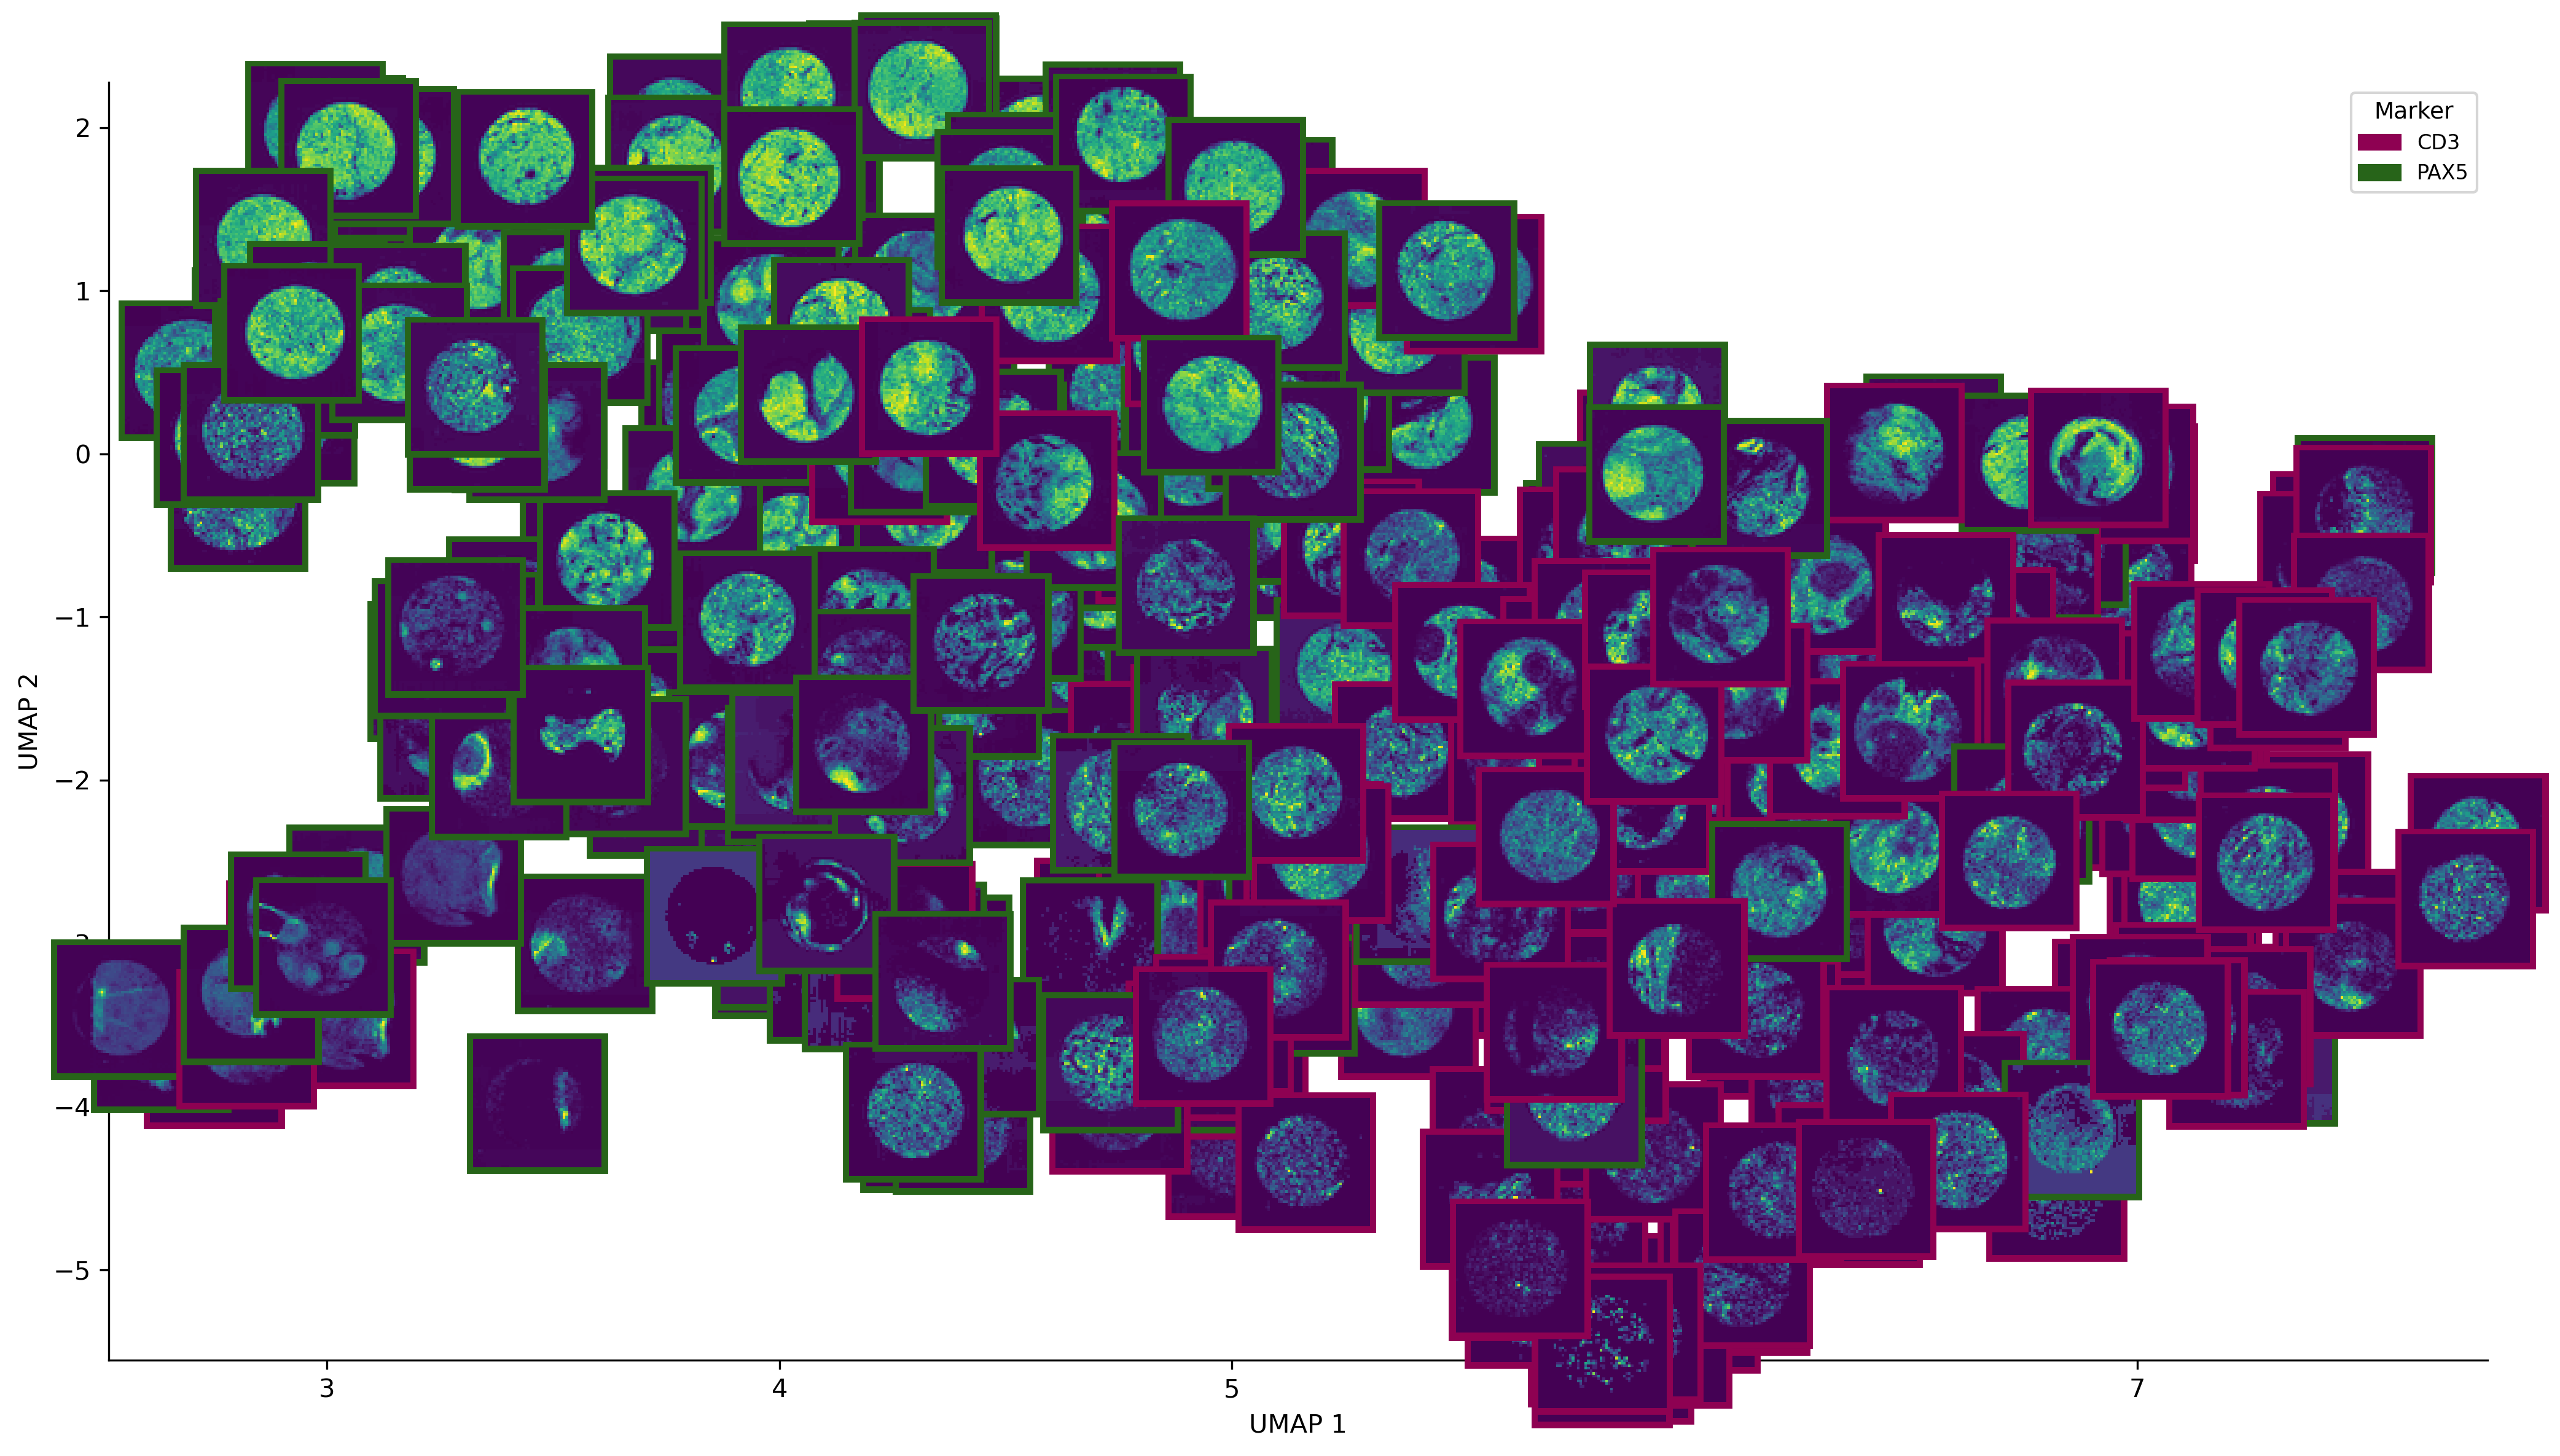

In [40]:
plot_umap_with_images_colored(df, image_size=(50, 50), fraction=0.5, colormap='PiYG')